In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
import numpy as np
import time
import jax.numpy as jnp
from jax import partial, jit, vmap, grad, random, lax
from jax.scipy.special import logsumexp

import context
from samplers.sgld import sgld_jaxloop, sgld_adam_time_budget
from samplers.sgldcv import sgld_jaxloop_CV
from samplers.sghmc import sghmc_scan, sghmc_time_budget
from samplers.mala import mala_sampler

from ksd import imq_KSD
from util import progress_bar_scan, wait_until_computed

# plot KSD as a function of time budget

See end of notebook for reproducing the figures

In [2]:

from examples.logistic_regression.logistic_regression_model import gen_data_and_log_post
from samplers.sgld import sgld, sgld_jaxloop, sgld_time_budget
from samplers.sgldcv import sgld_time_budget_CV


dim = 10
Ndata = 100000
key = random.PRNGKey(0) 
theta_true, X, y_data, val_and_grad_log_post = gen_data_and_log_post(key, dim, Ndata)

def _loglikelihood(theta, x_val, y_val):
        return -logsumexp(jnp.array([0., (1.-2.*y_val)*jnp.dot(theta, x_val)]))
    
_batch_loglik = jit(vmap(_loglikelihood, in_axes=(None, 0,0)))

@jit
def logloss(theta, X_test, y_test):
    return -jnp.mean(_batch_loglik(theta, X_test, y_test))

batch_logloss = jit(vmap(logloss, in_axes=(0, None, None)))

@partial(jit, static_argnums=(2,3,))
def get_logloss(key, dt, Nsamples, batch_size):
    x_0 = 0.2*random.normal(key, shape=theta_true.shape) + theta_true
    samples, grads = sgld_jaxloop(key, val_and_grad_log_post, X_train, y_train, Nsamples, dt, batch_size, x_0)
    logloss_array = batch_logloss(samples[:], X_test, y_test)
    return jnp.mean(logloss_array)

# testing and training data
num_train = int(Ndata*0.8)

X_train = X[:num_train]
X_test = X[num_train:]

y_train = y_data[:num_train]
y_test = y_data[num_train:]
print(X_train.shape, X_test.shape)


@jit
def fb_grads_LR_train(theta):
    return val_and_grad_log_post(theta, X_train, y_train)[1]

batch_fb_grads_LR_train = jit(vmap(fb_grads_LR_train, in_axes=(0,)))

generating data, with N=100000 and dim=10
(80000, 10) (20000, 10)


## Define functions

1. Get gradients in batches
2. get KSD list for different time budgets

In [3]:
def get_fb_grads_batches(samples, calc_batch_size):
    """
    Calculate the fullbatch gradients, but in batches
    """
    list_grads = []
    len_sgld = samples.shape[0]
    num_steps = int(np.ceil(len_sgld/calc_batch_size))
    for i in range(num_steps):
        new_grads = batch_fb_grads_LR_train(samples[i*calc_batch_size:(i+1)*calc_batch_size])
        wait_until_computed(new_grads)
        list_grads.append(new_grads)
#         if i%1==0:
#             print(f"i={i+1}/{num_steps}")
    fb_grads = jnp.concatenate(list_grads, axis=0)
#     print("Done.")
    return fb_grads

In [4]:
def get_KSD_list_time_budget_LR(max_time_budget, time_steps, sampler_fun, thin_step=1, start_time=1):
    ksd_list = []
    for time_budget in np.arange(start_time, max_time_budget, time_steps):
        print(f"Running for time budget={time_budget}sec")
        samples = sampler_fun(time_budget)
        print(f"Num samples: {np.shape(samples)[0]}")
        fb_grads = get_fb_grads_batches(samples[::thin_step], 5000)
        ksd_est = imq_KSD(samples[::thin_step], fb_grads)
        ksd_list.append(ksd_est)
        print("\n")
    return ksd_list
    


# SGLD

- default: `log_dt = -4.8`, `b_s_r = 0.1`

### old ones:
- SH, 1 sec:  `log_dt = -4.18`, `b_s_r = 0.46`
- SH, 5 sec: `log_dt = -4.69`, `b_s_r=0.033`


## Average KSD curves



### run for the 3 SH results

#### R = 5sec with n=90 (more configurations)


`key=11`:
- v1: -4.26, 0.20
- v2: -3.87, 0.22
- v3: -4.03, 0.19

`key=10`:
- v4: -4.77, 0.035
- v5: -5.03, 0.061
- v6: -4.18, 0.25

`key=9`:
- v7: -4.51, 0.053
- v8: -4.80, 0.040
- v9: -3.96, 0.071

 

In [5]:
def run_many_KSD_curves_sgld(list_params):
    list_KSD_curves = []
    
    starttime = time.time()
    for log_dt, b_s_r in list_params:
        print(f"\nCalculating KSD curve for {log_dt, b_s_r}:")
        def run_sgld_sampler(time_budget):
            key = random.PRNGKey(0)
            dt = 10**(log_dt)
            batch_size = int(X_train.shape[0]*b_s_r)
            x_0 = theta_true
            samples, _ = sgld_time_budget(key, val_and_grad_log_post, X_train, y_train, 
                                                           time_budget, dt, batch_size, x_0)
            return samples
        
        # ===
        max_time_budget = 8
        time_steps = 1
        thin_step = 5

        
        ksd_list_sgld_SH = get_KSD_list_time_budget_LR(max_time_budget, time_steps, run_sgld_sampler
                                                            , thin_step=thin_step)
        list_KSD_curves.append(ksd_list_sgld_SH)
    print(f"Running time: {time.time()-starttime:.2f} sec")
    return list_KSD_curves

In [6]:
# n=50
# list_params_sgld_5 = [(-5.35, 0.011), (-4.69, 0.033), (-4.12, 0.31), 
#                       (-4.97, 0.033), (-4.84, 0.023), (-4.79, 0.20),
#                      (-4.06, 0.093), (-4.85, 0.031), (-4.28, 0.043)]

# n=90
list_params_sgld_5 = [(-4.26, 0.20), (-3.87, 0.22), (-4.03, 0.19),
                     (-4.77, 0.035), (-5.03, 0.061), (-4.18, 0.25),
                      (-4.51, 0.053), (-4.80, 0.040), (-3.96, 0.071)
                     ]

# list_KSD_curves_sgld_5 = run_many_KSD_curves_sgld(list_params_sgld_5)

### load/save KSD curves for SH - 5 sec

In [5]:
# n=90
# save all KSD curves
# for idx, elem in enumerate(list_KSD_curves_sgld_5):
#     np.savetxt(f"outputs/KSD_list/LR/sgld-SH_5-n_90/ksd_curve_{idx}.csv", elem)

# load all KSD curves
list_KSD_curves_sgld_5 = []
for idx in range(9):
    mylist = np.genfromtxt(f"outputs/KSD_list/LR/sgld-SH_5-n_90/ksd_curve_{idx}.csv")
    list_KSD_curves_sgld_5.append(mylist)

In [20]:
# def sgld_sampler_default(time_budget):
#     key = random.PRNGKey(0)
#     dt = 10**(-4.8)
#     batch_size = int(X_train.shape[0]*0.1)
    
#     x_0 = theta_true
#     samples, _ = sgld_time_budget(key, val_and_grad_log_post, X_train, y_train, 
#                                                    time_budget, dt, batch_size, x_0)
#     return samples


# # ===
# max_time_budget = 8
# time_steps = 1
# thin_step = 5
# ksd_list_sgld_default = get_KSD_list_time_budget_LR(max_time_budget, time_steps, sgld_sampler_default, thin_step=thin_step)


# def sgld_sampler_adam(time_budget):
#     key = random.PRNGKey(0)
#     dt = 10**(-1.)
#     batch_size = int(X_train.shape[0]*0.1)
#     x_0 = theta_true
#     samples, _ = sgld_adam_time_budget(key, val_and_grad_log_post, X_train, y_train, time_budget, 
#                                             dt, batch_size, theta_true)
#     return samples


# # # ===
# max_time_budget = 8
# time_steps = 1
# thin_step = 5

# ksd_list_adam = get_KSD_list_time_budget_LR(max_time_budget, time_steps, sgld_sampler_adam, thin_step=thin_step)


### load/save KSD curves for adam and default samplers

In [21]:
# np.savetxt(f"outputs/KSD_list/LR/ksd_curve_adam.csv", ksd_list_adam)
# np.savetxt(f"outputs/KSD_list/LR/ksd_curve_sgld_default.csv", ksd_list_sgld_default)


ksd_list_adam = np.genfromtxt(f"outputs/KSD_list/LR/ksd_curve_adam.csv")
ksd_list_sgld_default = np.genfromtxt(f"outputs/KSD_list/LR/ksd_curve_sgld_default.csv")

### save KSD list arrays

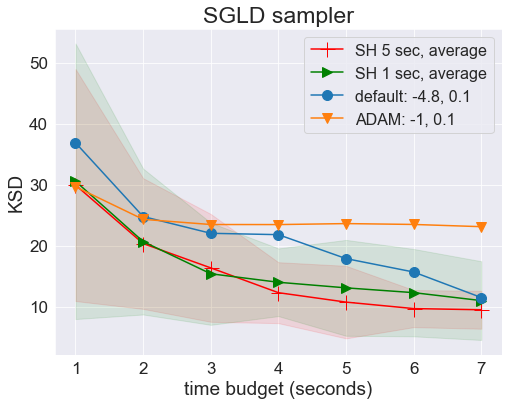

In [22]:
plt.rcParams.update({'font.size':17})

average_curve_sgld_SH5 = np.mean(list_KSD_curves_sgld_5, axis=0)
std_curve_sgld_SH5 = np.std(list_KSD_curves_sgld_5, axis=0)

# average_curve_sgld_SH5 = np.mean(list_KSD_curves_sgld_5_n30, axis=0)
# std_curve_sgld_SH5 = np.std(list_KSD_curves_sgld_5_n30, axis=0)

average_curve_sgld_SH1 = np.mean(list_KSD_curves_sgld_1, axis=0)
std_curve_sgld_SH1 = np.std(list_KSD_curves_sgld_1, axis=0)


max_time_budget = 8

plt.figure(figsize=(8, 6))

plt.plot(np.arange(1, max_time_budget), average_curve_sgld_SH5, marker="+", markersize=15, 
         c='r', label="SH 5 sec, average")
plt.fill_between(np.arange(1, max_time_budget), average_curve_sgld_SH5+2*std_curve_sgld_SH5, 
                 average_curve_sgld_SH5-2*std_curve_sgld_SH5, alpha=0.1, color='r')


plt.plot(np.arange(1, max_time_budget), average_curve_sgld_SH1, marker=">", markersize=10,
         c='green', label="SH 1 sec, average")
plt.fill_between(np.arange(1, max_time_budget), average_curve_sgld_SH1+2*std_curve_sgld_SH1, 
                 average_curve_sgld_SH1-2*std_curve_sgld_SH1, alpha=0.1, color='green')


# for elem in list_KSD_curves_sgld_5[:]:
#     plt.plot(np.arange(1, max_time_budget), elem, alpha=0.4, marker="v")

# plt.plot(np.arange(1, max_time_budget), list_KSD_curves_sgld_1[5], alpha=0.4, marker="v", lw=10)
    
plt.plot(np.arange(1, max_time_budget), ksd_list_sgld_default, marker="o", label="default: -4.8, 0.1", markersize=10)
plt.plot(np.arange(1, max_time_budget), ksd_list_adam, marker="v", label="ADAM: -1, 0.1", markersize=10)

plt.title("SGLD sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgld_ksd_curves_R1_R5_n90.png")

# sgld-CV

In [17]:
def run_many_KSD_curves_sgldCV(list_params):
    list_KSD_curves = []
    
    starttime = time.time()
    for log_dt, b_s_r in list_params:
        print(f"\nCalculating KSD curve for {log_dt, b_s_r}:")
        def run_sgld_sampler(time_budget):
            key = random.PRNGKey(0)
            dt = 10**(log_dt)
            batch_size = int(X_train.shape[0]*b_s_r)
            x_0 = theta_true
            samples, _ = sgld_time_budget_CV(key, val_and_grad_log_post, 
                      X_train, y_train, time_budget, dt, batch_size, x_0, x_0)
            return samples
        
        # ===
        max_time_budget = 8
        time_steps = 1
        thin_step = 5

        
        ksd_list_sgld_SH = get_KSD_list_time_budget_LR(max_time_budget, time_steps, run_sgld_sampler
                                                            , thin_step=thin_step)
        list_KSD_curves.append(ksd_list_sgld_SH)
    print(f"Running time: {time.time()-starttime:.2f} sec")
    return list_KSD_curves


#### R = 5sec - n=90

`key=11`:
- v1: -3.89, 0.0019
- v2: -4.13, 0.019
- v3: -3.74, 0.0087

`key=10`:
- v4: -3.92, 0.0057
- v5: -3.91, 0.0087
- v6: -3.92, 0.0035

`key=9`:
- v7: -3.81, 0.01
- v8: -3.80, 0.0014
- v9: -3.99, 0.0046


In [19]:
# n=90
list_params_sgldCV_5 = [(-3.89, 0.0019), (-4.13, 0.019), (-3.74, 0.0087),
                        (-3.92, 0.0057), (-3.91, 0.0087), (-3.92, 0.0035),
                        (-3.81, 0.01), (-3.80, 0.0014), (-3.99, 0.0046)
                       ]

# list_KSD_curves_sgldCV_5 = run_many_KSD_curves_sgldCV(list_params_sgldCV_5)

In [5]:
# n=90
# # save all KSD curves for R=5
# for idx, elem in enumerate(list_KSD_curves_sgldCV_5):
#     np.savetxt(f"outputs/KSD_list/LR/sgldCV-SH_5-n_90/ksd_curve_{idx}.csv", elem)

# # load all KSD curves
list_KSD_curves_sgldCV_5 = []
for idx in range(9):
    mylist = np.genfromtxt(f"outputs/KSD_list/LR/sgldCV-SH_5-n_90/ksd_curve_{idx}.csv") # with thin_step=5
    list_KSD_curves_sgldCV_5.append(mylist)
    
len(list_KSD_curves_sgldCV_5)

9

### plot distribution of parameters

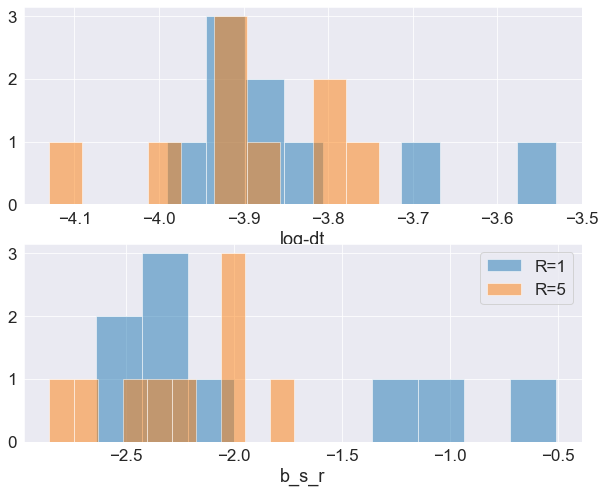

In [26]:
logdt_list_sgldCV_1 = [elem[0] for elem in list_params_sgldCV_1]
b_s_r_list_sgldCV_1 = [elem[1] for elem in list_params_sgldCV_1]

logdt_list_sgldCV_5 = [elem[0] for elem in list_params_sgldCV_5]
b_s_r_list_sgldCV_5 = [elem[1] for elem in list_params_sgldCV_5]

fig, ax = plt.subplots(2, figsize=(10,8))

ax[0].hist(logdt_list_sgldCV_1, alpha=0.5, label="R=1")
ax[0].hist(logdt_list_sgldCV_5, alpha=0.5, label="R=5")
ax[0].set_xlabel("log-dt", size=18)

ax[1].hist(np.log10(b_s_r_list_sgldCV_1), alpha=0.5, label="R=1")
ax[1].hist(np.log10(b_s_r_list_sgldCV_5), alpha=0.5, label="R=5")

ax[1].set_xlabel("b_s_r", size=18)

plt.legend()

### run default sampler

In [27]:
# def sgldCV_sampler_default(time_budget):
#     key = random.PRNGKey(0)
#     dt = 10**(-4.2)
#     batch_size = int(X_train.shape[0]*0.1)
#     x_0 = theta_true
#     samples, _ = sgld_time_budget_CV(key, val_and_grad_log_post, 
#                       X_train, y_train, time_budget, dt, batch_size, x_0, x_0)
#     return samples


# # ===
# max_time_budget = 8
# time_steps = 1
# thin_step = 5
# # thin_step = 1

# ksd_list_sgldCV_default_thin1 = get_KSD_list_time_budget_LR(max_time_budget, time_steps, 
#                                                       sgldCV_sampler_default, thin_step=thin_step)

In [7]:
# default, thin=1
# np.savetxt(f"outputs/KSD_list/LR/ksd_curve_sgldCV_default_thin1.csv", ksd_list_sgldCV_default_thin1)
# ksd_list_sgldCV_default = np.genfromtxt(f"outputs/KSD_list/LR/ksd_curve_sgldCV_default_thin1.csv")

# default, thin=5
# np.savetxt(f"outputs/KSD_list/LR/ksd_curve_sgldCV_default.csv", ksd_list_sgldCV_default)
ksd_list_sgldCV_default = np.genfromtxt(f"outputs/KSD_list/LR/ksd_curve_sgldCV_default.csv")

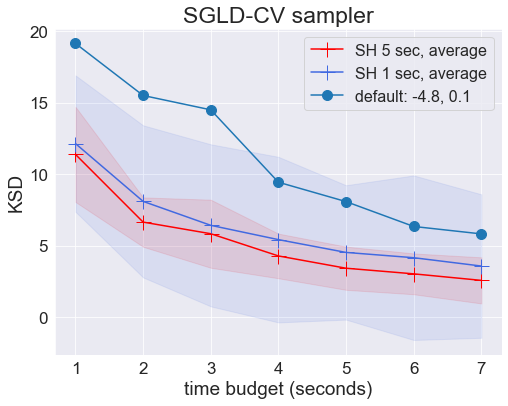

In [29]:
plt.rcParams.update({'font.size':17})

average_curve_sgldCV_SH5 = np.mean(list_KSD_curves_sgldCV_5, axis=0)
std_curve_sgldCV_SH5 = np.std(list_KSD_curves_sgldCV_5, axis=0)

average_curve_sgldCV_SH1 = np.mean(list_KSD_curves_sgldCV_1, axis=0)
std_curve_sgldCV_SH1= np.std(list_KSD_curves_sgldCV_1, axis=0)


max_time_budget = 8

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, max_time_budget), average_curve_sgldCV_SH5, marker="+", markersize=15, 
         c='r', label="SH 5 sec, average")
plt.fill_between(np.arange(1, max_time_budget), average_curve_sgldCV_SH5+2*std_curve_sgldCV_SH5, 
                 average_curve_sgldCV_SH5-2*std_curve_sgldCV_SH5, alpha=0.1, color='r')


plt.plot(np.arange(1, max_time_budget), average_curve_sgldCV_SH1, marker="+", markersize=15,
         c='royalblue', label="SH 1 sec, average")
plt.fill_between(np.arange(1, max_time_budget), average_curve_sgldCV_SH1+2*std_curve_sgldCV_SH1, 
                 average_curve_sgldCV_SH1-2*std_curve_sgldCV_SH1, alpha=0.1, color='royalblue')
    
# for elem in list_KSD_curves_sgldCV_1[:]:
#     plt.plot(np.arange(1, max_time_budget), elem, alpha=0.4, marker="+")    
    
    
plt.plot(np.arange(1, max_time_budget), ksd_list_sgldCV_default, marker="o", label="default: -4.8, 0.1", markersize=10)

plt.title("SGLD-CV sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sgldCV_ksd_curves_1_and_5-n_90.png")

# SGHMC: tune leapfrog step

- default: `log_dt=-6`, `b_s_r=0.1`, `L=11`
- SH 12 sec (old run): `log_dt=-6.3`, `b_s_r=0.045`, `L=28``
- SH 10 seconds (new run): `log_dt=-6.98`, `b_s_r=0.0042`, `L=12``



In [30]:
def run_many_KSD_curves_sghmc(list_params):
    list_KSD_curves = []
    
    starttime = time.time()
    for log_dt, b_s_r, L in list_params:
        print(f"\nCalculating KSD curve for {log_dt, b_s_r, L}:")
        def run_sghmc_sampler(time_budget):
            key = random.PRNGKey(0)
            dt = 10**(log_dt)
            batch_size = int(X_train.shape[0]*b_s_r)
            x_0 = theta_true
            alpha = 0.01
            samples, _ = sghmc_time_budget(key, val_and_grad_log_post, X_train, y_train, 
                                   time_budget, dt, batch_size, x_0, alpha, L,)
            return samples
        
        # ===
        max_time_budget = 15
        time_steps = 1
        thin_step = 5

        
        ksd_list_sgld_SH = get_KSD_list_time_budget_LR(max_time_budget, time_steps, run_sghmc_sampler
                                                            , thin_step=thin_step)
        list_KSD_curves.append(ksd_list_sgld_SH)
    print(f"Running time: {time.time()-starttime:.2f} sec")
    return list_KSD_curves

#### R=10 - n=120



`key=11`:
- v1: -6.97, 0.0042, 22
- v2: -6.19, 0.014, 18
- v3: -5.71, 0.057, 8

`key=10`:
- v4: -6.61, 0.014, 18
- v5: -5.63, 0.022, 5
- v6: -5.65, 0.017, 6

`key=9`:
- v7: -6.63, 0.045, 24
- v8: -6.58, 0.014, 14
- v9: -5.96, 0.073, 15



In [31]:
list_params_sghmc_10 = [(-6.97, 0.0042, 22), (-6.19, 0.0137, 18), (-5.705, 0.057, 8),
                       (-6.61, 0.014, 18), (-5.65, 0.017, 6), (-5.63, 0.022, 5),
                       (-6.30, 0.022, 11), (-6.58, 0.014, 14), (-6.63, 0.045, 24)
                       ]

# list_KSD_curves_sghmc_10 = run_many_KSD_curves_sghmc(list_params_sghmc_10)


In [8]:
# n=120
# # save all KSD curves for R=10
# for idx, elem in enumerate(list_KSD_curves_sghmc_10):
#     np.savetxt(f"outputs/KSD_list/LR/sghmc-SH_10/ksd_curve_{idx}.csv", elem)

# # load all KSD curves
list_KSD_curves_sghmc_10 = []
for idx in range(9):
    mylist = np.genfromtxt(f"outputs/KSD_list/LR/sghmc-SH_10/ksd_curve_{idx}.csv")
    list_KSD_curves_sghmc_10.append(mylist)
    
len(list_KSD_curves_sghmc_10)


9

In [35]:
# def sghmc_sampler_default(time_budget):
#     key = random.PRNGKey(0)
#     batch_size = int(0.1*X_train.shape[0])
#     dt = 10**(-6.)
#     alpha = 0.01
#     L = 11
#     x_0 = theta_true
#     samples, _ = sghmc_time_budget(key, val_and_grad_log_post, X_train, y_train, 
#                                        time_budget, dt, batch_size, x_0, alpha, L,)
#     return samples


# # ===
# max_time_budget = 15
# time_steps = 1
# thin_step = 5

# ksd_list_sghmc_default = get_KSD_list_time_budget_LR(max_time_budget, time_steps, sghmc_sampler_default, thin_step)



In [10]:
dir_base = "outputs/KSD_list/LR"


# np.savetxt(f"{dir_base}/ksd_list_LR_sghmc_default.txt", ksd_list_sghmc_default)


ksd_list_sghmc_default = np.genfromtxt(f"{dir_base}/ksd_list_LR_sghmc_default.txt")

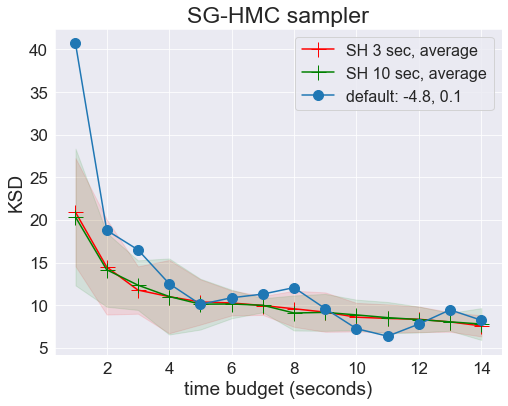

In [37]:
plt.rcParams.update({'font.size':17})

average_curve_sghmc_SH3 = np.mean(list_KSD_curves_sghmc_3, axis=0)
std_curve_sghmc_SH3 = np.std(list_KSD_curves_sghmc_3, axis=0)

average_curve_sghmc_SH10 = np.mean(list_KSD_curves_sghmc_10, axis=0)
std_curve_sghmc_SH10 = np.std(list_KSD_curves_sghmc_10, axis=0)


max_time_budget = 15

plt.figure(figsize=(8, 6))
plt.plot(np.arange(1, max_time_budget), average_curve_sghmc_SH3, marker="+", markersize=15, 
         c='r', label="SH 3 sec, average")
plt.fill_between(np.arange(1, max_time_budget), average_curve_sghmc_SH3+2*std_curve_sghmc_SH3, 
                 average_curve_sghmc_SH3-2*std_curve_sghmc_SH3, alpha=0.1, color='r')


plt.plot(np.arange(1, max_time_budget), average_curve_sghmc_SH10, marker="+", markersize=15, 
         c='g', label="SH 10 sec, average")
plt.fill_between(np.arange(1, max_time_budget), average_curve_sghmc_SH10+2*std_curve_sghmc_SH10, 
                 average_curve_sghmc_SH10-2*std_curve_sghmc_SH10, alpha=0.1, color='g')
    
# for elem in list_KSD_curves_sghmc_10[:]:
#     plt.plot(np.arange(1, max_time_budget), elem, alpha=0.4, marker="+")    
    
    
plt.plot(np.arange(1, max_time_budget), ksd_list_sghmc_default, marker="o", label="default: -4.8, 0.1", markersize=10)

plt.title("SG-HMC sampler", size=23)
plt.ylabel("KSD", size=19)
plt.xlabel("time budget (seconds)", size=19)
plt.legend(fontsize=16)
# plt.savefig("images/sghmc_ksd_curves_R3_and_R10-n_90.png")

# 3 plots together

## plot for 1 time budget

In [2]:
dir_base = "outputs/KSD_list/LR"

# SGLD
list_KSD_curves_sgld_5 = []
for idx in range(9):
    mylist = np.genfromtxt(f"outputs/KSD_list/LR/sgld-SH_5-n_90/ksd_curve_{idx}.csv")
    list_KSD_curves_sgld_5.append(mylist)
    
    
    
ksd_list_adam = np.genfromtxt(f"outputs/KSD_list/LR/ksd_curve_adam.csv")
ksd_list_sgld_default = np.genfromtxt(f"outputs/KSD_list/LR/ksd_curve_sgld_default.csv")

# SGLD-CV
list_KSD_curves_sgldCV_5 = []
for idx in range(9):
    mylist = np.genfromtxt(f"outputs/KSD_list/LR/sgldCV-SH_5-n_90/ksd_curve_{idx}.csv") # with thin_step=5
    list_KSD_curves_sgldCV_5.append(mylist)
    
ksd_list_sgldCV_default = np.genfromtxt(f"outputs/KSD_list/LR/ksd_curve_sgldCV_default.csv")


# SGHMC

list_KSD_curves_sghmc_10 = []
for idx in range(9):
    mylist = np.genfromtxt(f"outputs/KSD_list/LR/sghmc-SH_10/ksd_curve_{idx}.csv")
    list_KSD_curves_sghmc_10.append(mylist)
    
ksd_list_sghmc_default = np.genfromtxt(f"{dir_base}/ksd_list_LR_sghmc_default.txt")

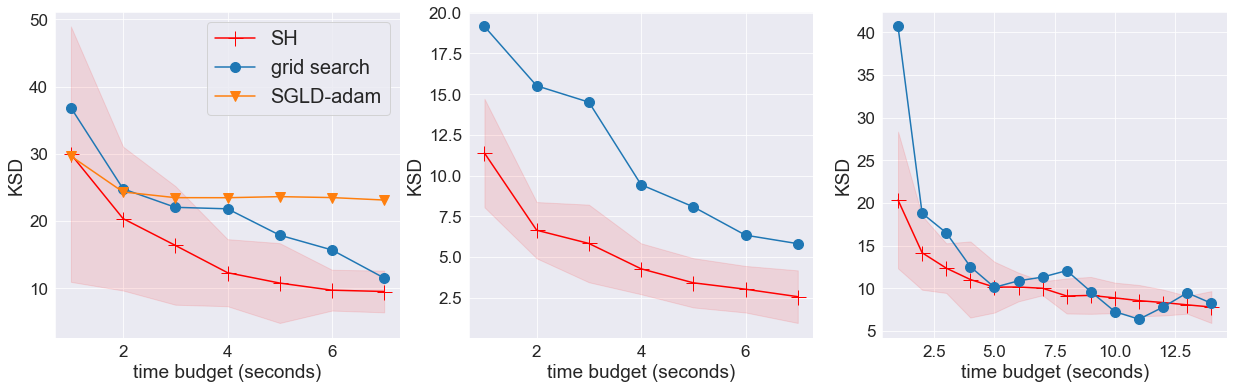

In [6]:
plt.rcParams.update({'font.size':17})
fig, ax = plt.subplots(1,3, figsize=(21, 6))


# ===============
# SGLD
average_curve_sgld_SH5 = np.mean(list_KSD_curves_sgld_5, axis=0)
std_curve_sgld_SH5 = np.std(list_KSD_curves_sgld_5, axis=0)

max_time_budget_sgld = 8

ax[0].plot(np.arange(1, max_time_budget_sgld), average_curve_sgld_SH5, marker="+", markersize=15, 
         c='r', label="SH")
ax[0].fill_between(np.arange(1, max_time_budget_sgld), average_curve_sgld_SH5+2*std_curve_sgld_SH5, 
                 average_curve_sgld_SH5-2*std_curve_sgld_SH5, alpha=0.1, color='r')

ax[0].plot(np.arange(1, max_time_budget_sgld), ksd_list_sgld_default, marker="o", label="grid search", markersize=10)
ax[0].plot(np.arange(1, max_time_budget_sgld), ksd_list_adam, marker="v", label="SGLD-adam", markersize=10)


# ax[0].set_title("SGLD sampler", size=23)
ax[0].set_ylabel("KSD", size=19)
ax[0].set_xlabel("time budget (seconds)", size=19)
# ax[0].legend(fontsize=20)



# ===============
# SGLD-CV

average_curve_sgldCV_SH5 = np.mean(list_KSD_curves_sgldCV_5, axis=0)
std_curve_sgldCV_SH5 = np.std(list_KSD_curves_sgldCV_5, axis=0)

max_time_budget_sgldCV = 8

ax[1].plot(np.arange(1, max_time_budget_sgldCV), average_curve_sgldCV_SH5, marker="+", markersize=15, 
         c='r', label="SH")
ax[1].fill_between(np.arange(1, max_time_budget_sgldCV), average_curve_sgldCV_SH5+2*std_curve_sgldCV_SH5, 
                 average_curve_sgldCV_SH5-2*std_curve_sgldCV_SH5, alpha=0.1, color='r')

ax[1].plot(np.arange(1, max_time_budget_sgldCV), ksd_list_sgldCV_default, marker="o", label="grid search", markersize=10)

# ax[1].set_title("SGLD-CV sampler", size=23)
ax[1].set_ylabel("KSD", size=19)
ax[1].set_xlabel("time budget (seconds)", size=19)
# ax[1].legend(fontsize=20)


# ==================
# SG-HMC
average_curve_sghmc_SH10 = np.mean(list_KSD_curves_sghmc_10, axis=0)
std_curve_sghmc_SH10 = np.std(list_KSD_curves_sghmc_10, axis=0)

max_time_budget_sghmc = 15

ax[2].plot(np.arange(1, max_time_budget_sghmc), average_curve_sghmc_SH10, marker="+", markersize=15, 
         c='r', label="SH")
ax[2].fill_between(np.arange(1, max_time_budget_sghmc), average_curve_sghmc_SH10+2*std_curve_sghmc_SH10, 
                 average_curve_sghmc_SH10-2*std_curve_sghmc_SH10, alpha=0.1, color='r')
    
ax[2].plot(np.arange(1, max_time_budget_sghmc), ksd_list_sghmc_default, marker="o", label="grid search", markersize=10)

# ax[2].set_title("SG-HMC sampler", size=23)
ax[2].set_ylabel("KSD", size=19)
ax[2].set_xlabel("time budget (seconds)", size=19)
ax[0].legend(fontsize=20)

# plt.savefig("images/LR_KSD_curves.png")



## plot for 2 time budgets